In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from model import MiniTransformer
from tqdm import tqdm
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

Using device: cuda


In [2]:
# Step 1: Load a small portion of the file
max_chars = 200_000_000  # Adjust depending on your RAM (1 million = ~1MB of text)

text = ""
with open("TinyStories-train.txt", "r", encoding="utf-8", errors="ignore") as f:
    while len(text) < max_chars:
        line = f.readline()
        if not line:
            break
        text += line

print(f"Loaded {len(text):,} characters of text.")

# Step 2: Build character-level vocabulary
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(f"Vocabulary size: {vocab_size}")

stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for ch, i in stoi.items()}

def encode(s):
    return [stoi[c] for c in s]

def decode(l):
    return ''.join([itos[i] for i in l])

# Step 3: Convert to tensor efficiently
ids = [stoi[c] for c in text if c in stoi]
data = torch.tensor(ids, dtype=torch.long)
print("Data shape:", data.shape)

Loaded 200,000,075 characters of text.
Vocabulary size: 121
Data shape: torch.Size([200000075])


In [3]:
# Split into training and validation sets
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

# Set model input parameters
block_size = 64  # context window length
batch_size = 32  # number of sequences per batch

# Batch sampling function
def get_batch(split):
    data_split = train_data if split == 'train' else val_data
    ix = torch.randint(len(data_split) - block_size, (batch_size,))
    x = torch.stack([data_split[i:i+block_size] for i in ix])
    y = torch.stack([data_split[i+1:i+block_size+1] for i in ix])
    return x.to(device), y.to(device)

In [4]:
model = MiniTransformer(vocab_size=vocab_size).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

In [5]:
def evaluate(num_batches=100):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_tokens = 0
    with torch.no_grad():
        for _ in range(num_batches):
            xb, yb = get_batch('val')
            logits = model(xb)
            loss = F.cross_entropy(logits.view(-1, vocab_size), yb.view(-1))
            preds = torch.argmax(logits, dim=-1)
            correct = (preds == yb).float().sum().item()
            total_correct += correct
            total_tokens += yb.numel()
            total_loss += loss.item()

    return total_loss / num_batches, total_correct / total_tokens

In [6]:
max_steps = 1000000
eval_interval = 100000
train_losses = []
val_losses = []
val_accuracies = []

for step in tqdm(range(max_steps)):
    model.train()
    xb, yb = get_batch('train')
    logits = model(xb)
    loss = F.cross_entropy(logits.view(-1, vocab_size), yb.view(-1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    # Evaluate on validation set occasionally
    if step % eval_interval == 0 or step == max_steps - 1:
        val_loss, val_acc = evaluate()
        val_losses.append((step, val_loss))
        val_accuracies.append((step, val_acc))
        print(f"Step {step}: train_loss = {loss.item():.4f}, val_loss = {val_loss:.4f}, val_acc = {val_acc * 100:.2f}%")


  0%|                                                         | 2/1000000 [00:03<393:39:38,  1.42s/it]

Step 0: train_loss = 4.9157, val_loss = 4.7831, val_acc = 2.15%


 10%|█████▎                                               | 100008/1000000 [29:36<23:10:20, 10.79it/s]

Step 100000: train_loss = 1.0829, val_loss = 0.9440, val_acc = 69.91%


 20%|██████████▏                                        | 200010/1000000 [1:00:48<12:15:16, 18.13it/s]

Step 200000: train_loss = 1.0808, val_loss = 0.8973, val_acc = 71.34%


 30%|███████████████▎                                   | 300009/1000000 [1:31:01<11:18:25, 17.20it/s]

Step 300000: train_loss = 0.9729, val_loss = 0.8787, val_acc = 72.02%


 40%|████████████████████▊                               | 400009/1000000 [1:59:39<8:29:34, 19.62it/s]

Step 400000: train_loss = 0.8961, val_loss = 0.8659, val_acc = 72.33%


 50%|██████████████████████████                          | 500008/1000000 [2:29:22<9:21:22, 14.84it/s]

Step 500000: train_loss = 0.9194, val_loss = 0.8561, val_acc = 72.54%


 60%|██████████████████████████████▌                    | 600009/1000000 [3:01:53<10:58:53, 10.12it/s]

Step 600000: train_loss = 0.8675, val_loss = 0.8521, val_acc = 72.65%


 70%|████████████████████████████████████▍               | 700009/1000000 [3:32:41<3:54:47, 21.30it/s]

Step 700000: train_loss = 0.9061, val_loss = 0.8422, val_acc = 73.10%


 80%|█████████████████████████████████████████▌          | 800011/1000000 [4:02:43<5:10:20, 10.74it/s]

Step 800000: train_loss = 0.9588, val_loss = 0.8352, val_acc = 73.22%


 90%|██████████████████████████████████████████████▊     | 900009/1000000 [4:35:51<2:17:36, 12.11it/s]

Step 900000: train_loss = 0.9184, val_loss = 0.8381, val_acc = 73.18%


100%|█████████████████████████████████████████████████████| 1000000/1000000 [5:05:25<00:00, 54.57it/s]

Step 999999: train_loss = 0.8520, val_loss = 0.8299, val_acc = 73.47%


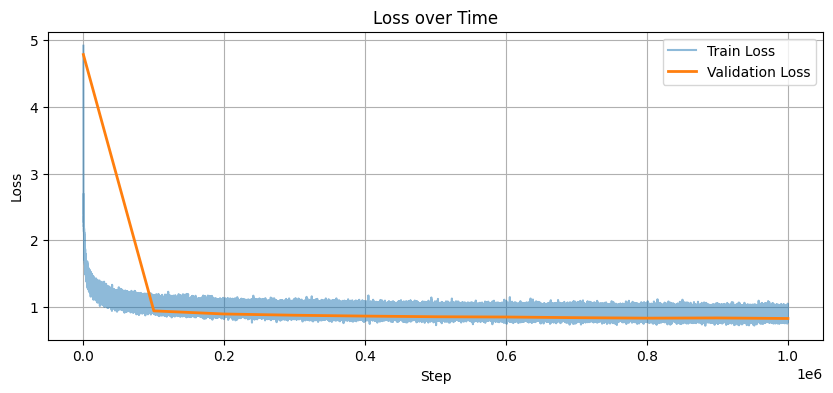

In [7]:
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label="Train Loss", alpha=0.5)
steps, vlosses = zip(*val_losses)
plt.plot(steps, vlosses, label="Validation Loss", linewidth=2)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss over Time")
plt.grid(True)
plt.show()


In [8]:
torch.save({
    'model_state_dict': model.state_dict(),
    'stoi': stoi,
    'itos': itos,
    'vocab_size': vocab_size
}, "mini_llm_checkpoint.pt")